<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/CNN_GRU/CNN_GRU_Bund10y.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 150, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 150 (delta 73), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (150/150), 121.14 KiB | 1.48 MiB/s, done.
Resolving deltas: 100% (73/73), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Wed Jul 21 18:15:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'Bund10y'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'CNN_GRU'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len, time_distributed=True)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8 MB 4.4 MB/s 
     |████████████████████████████████| 97 kB 8.2 MB/s 
     |████████████████████████████████| 133 kB 53.7 MB/s 
     |████████████████████████████████| 138 kB 71.6 MB/s 
     |████████████████████████████████| 170 kB 77.9 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 62 kB 1.0 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop', 'sgd']
        },
        'activation': {
            'values': ['relu', 'selu']
        }
    }
}

In [13]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

    # layer 1
    model.add(TimeDistributed(Conv1D(filters=128, kernel_size=2, activation=config.activation), input_shape=(None, window_len, 1)))
    # layer 2
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    # layer 3
    model.add(TimeDistributed(Flatten()))
    # layer 4
    model.add(GRU(units=128, activation='tanh', return_sequences=False))
    # layer 5
    model.add(Dropout(0.1))
    # layer 6
    model.add(Dense(1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: 5fv2ssf2
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_CNN_GRU/sweeps/5fv2ssf2


In [15]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: wwq6bptp with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/200
8/8 [==============================] - 35s 144ms/step - loss: 0.1024 - mean_squared_error: 0.1024 - mean_absolute_error: 0.2275 - val_loss: 0.0249 - val_mean_squared_error: 0.0249 - val_mean_absolute_error: 0.1313
Epoch 2/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0543 - val_loss: 0.0314 - val_mean_squared_error: 0.0314 - val_mean_absolute_error: 0.1369
Epoch 3/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0252 - mean_squared_error: 0.0252 - mean_absolute_error: 0.1236 - val_loss: 0.0203 - val_mean_squared_error: 0.0203 - val_mean_absolute_error: 0.1166
Epoch 4/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0467 - val_loss: 0.0190 - val_mean_squared_error: 0.0190 - val_mean_absolute_error: 0.1129
Epoch 5/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0028 - mean_squared_error: 0.00

epoch,86
loss,0.00129
mean_squared_error,0.00129
mean_absolute_error,0.02796
val_loss,0.00702
val_mean_squared_error,0.00702
val_mean_absolute_error,0.06436
_runtime,51
_timestamp,1626891443
_step,86
best_val_loss,0.00593


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▇▂▂▂▂▂▂▁▂▂▁▂▁▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▆▆▃▃▂▃▄▂▂▂▂▂▂▂▁▁▁▂▃▂▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁
val_mean_squared_error,█▆▆▆▆▃▃▂▃▄▂▂▂▂▂▂▂▁▁▁▂▃▂▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▆▇▃▃▃▃▅▃▂▂▂▂▂▂▂▂▁▂▃▂▁▁▁▁▂▁▂▁▁▁▂▁▁▁▂▂▂
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 0x585gsj with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 3s 107ms/step - loss: 0.6138 - mean_squared_error: 0.6138 - mean_absolute_error: 0.4703 - val_loss: 0.0216 - val_mean_squared_error: 0.0216 - val_mean_absolute_error: 0.1206
Epoch 2/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0410 - val_loss: 0.0220 - val_mean_squared_error: 0.0220 - val_mean_absolute_error: 0.1224
Epoch 3/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0406 - val_loss: 0.0195 - val_mean_squared_error: 0.0195 - val_mean_absolute_error: 0.1114
Epoch 4/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0337 - mean_squared_error: 0.0337 - mean_absolute_error: 0.1329 - val_loss: 0.0201 - val_mean_squared_error: 0.0201 - val_mean_absolute_error: 0.1135
Epoch 5/200
8/8 [==============================] - 0s 6ms/step - loss: 0.0049 - mean_squared_error: 0.0049

epoch,39
loss,0.00225
mean_squared_error,0.00225
mean_absolute_error,0.03624
val_loss,0.01248
val_mean_squared_error,0.01248
val_mean_absolute_error,0.08821
_runtime,10
_timestamp,1626891465
_step,39
best_val_loss,0.00945


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▅▁▄▂▃▃▃▁▃▂▂▁▂▁▂▂▂▁▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄▄▄▄▃▆▅▃█▃▂▃▂▃▂▄▂▃▅▂▂▂▁▅▁▄▁▁▂▁▅▁▁▂▁▃▁▂▁▂
val_mean_squared_error,▄▄▄▄▃▆▅▃█▃▂▃▂▃▂▄▂▃▅▂▂▂▁▅▁▄▁▁▂▁▅▁▁▂▁▃▁▂▁▂
val_mean_absolute_error,▅▅▄▄▄▇▆▄█▃▃▃▂▃▂▅▃▄▅▂▃▃▁▅▁▄▂▁▂▁▅▁▁▂▁▃▁▂▁▂
_runtime,▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆███████
_timestamp,▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆███████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: t9er7uj6 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
32/32 [==============================] - 4s 39ms/step - loss: 1.8122 - mean_squared_error: 1.8122 - mean_absolute_error: 0.5944 - val_loss: 0.0160 - val_mean_squared_error: 0.0160 - val_mean_absolute_error: 0.1010
Epoch 2/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0646 - val_loss: 0.0165 - val_mean_squared_error: 0.0165 - val_mean_absolute_error: 0.1029
Epoch 3/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0407 - val_loss: 0.0197 - val_mean_squared_error: 0.0197 - val_mean_absolute_error: 0.1116
Epoch 4/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0435 - val_loss: 0.0085 - val_mean_squared_error: 0.0085 - val_mean_absolute_error: 0.0721
Epoch 5/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.

epoch,13
loss,0.00209
mean_squared_error,0.00209
mean_absolute_error,0.03462
val_loss,0.00979
val_mean_squared_error,0.00979
val_mean_absolute_error,0.07744
_runtime,11
_timestamp,1626891489
_step,13
best_val_loss,0.0085


epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
loss,█▁▁▁▁▁▅▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▅▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▇▁▁▁▁▁▁▁
val_loss,▅▅▇▁▁▂▇█▄▃▃▃▂▂
val_mean_squared_error,▅▅▇▁▁▂▇█▄▃▃▃▂▂
val_mean_absolute_error,▅▅▆▁▁▂▆█▄▃▃▃▂▂
_runtime,▁▁▁▁▃▃▃▃▃▆▆▆▆█
_timestamp,▁▁▁▁▃▃▃▃▃▆▆▆▆█
_step,▁▂▂▃▃▄▄▅▅▆▆▇▇█


wandb: Agent Starting Run: pf8nawsx with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 4s 59ms/step - loss: 0.0369 - mean_squared_error: 0.0369 - mean_absolute_error: 0.1449 - val_loss: 0.0456 - val_mean_squared_error: 0.0456 - val_mean_absolute_error: 0.1810
Epoch 2/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0671 - val_loss: 0.0281 - val_mean_squared_error: 0.0281 - val_mean_absolute_error: 0.1416
Epoch 3/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0470 - val_loss: 0.0222 - val_mean_squared_error: 0.0222 - val_mean_absolute_error: 0.1239
Epoch 4/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0394 - val_loss: 0.0198 - val_mean_squared_error: 0.0198 - val_mean_absolute_error: 0.1157
Epoch 5/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0020 - mean_squared_erro

epoch,71
loss,0.00079
mean_squared_error,0.00079
mean_absolute_error,0.0216
val_loss,0.00904
val_mean_squared_error,0.00904
val_mean_absolute_error,0.07398
_runtime,17
_timestamp,1626891517
_step,71
best_val_loss,0.00653


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▃▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▃▃▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▄▄▃▃▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▁▂▂▁▁▁▁▂▁▂▁▁▁▁▂▁▁▂▂
_runtime,▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: cliw6f3p with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 3s 53ms/step - loss: 0.0648 - mean_squared_error: 0.0648 - mean_absolute_error: 0.1885 - val_loss: 0.0318 - val_mean_squared_error: 0.0318 - val_mean_absolute_error: 0.1392
Epoch 2/100
16/16 [==============================] - 0s 5ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - mean_absolute_error: 0.0830 - val_loss: 0.0349 - val_mean_squared_error: 0.0349 - val_mean_absolute_error: 0.1590
Epoch 3/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0490 - val_loss: 0.0268 - val_mean_squared_error: 0.0268 - val_mean_absolute_error: 0.1381
Epoch 4/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0414 - val_loss: 0.0227 - val_mean_squared_error: 0.0227 - val_mean_absolute_error: 0.1248
Epoch 5/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0024 - mean_squared_erro

epoch,74
loss,0.00078
mean_squared_error,0.00078
mean_absolute_error,0.02144
val_loss,0.00789
val_mean_squared_error,0.00789
val_mean_absolute_error,0.06906
_runtime,18
_timestamp,1626891547
_step,74
best_val_loss,0.00673


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇█▅▄▄▃▃▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▇█▅▄▄▃▃▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▇█▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: r0abgw5g with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/50
32/32 [==============================] - 3s 29ms/step - loss: 0.1381 - mean_squared_error: 0.1381 - mean_absolute_error: 0.3128 - val_loss: 0.0845 - val_mean_squared_error: 0.0845 - val_mean_absolute_error: 0.2282
Epoch 2/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0387 - mean_squared_error: 0.0387 - mean_absolute_error: 0.1410 - val_loss: 0.0395 - val_mean_squared_error: 0.0395 - val_mean_absolute_error: 0.1608
Epoch 3/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0182 - mean_squared_error: 0.0182 - mean_absolute_error: 0.1014 - val_loss: 0.0334 - val_mean_squared_error: 0.0334 - val_mean_absolute_error: 0.1494
Epoch 4/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0158 - mean_squared_error: 0.0158 - mean_absolute_error: 0.0997 - val_loss: 0.0316 - val_mean_squared_error: 0.0316 - val_mean_absolute_error: 0.1457
Epoch 5/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0128 - mean_squared_error: 0.

epoch,49
loss,0.00263
mean_squared_error,0.00263
mean_absolute_error,0.03913
val_loss,0.02379
val_mean_squared_error,0.02379
val_mean_absolute_error,0.1299
_runtime,18
_timestamp,1626891577
_step,49
best_val_loss,0.02372


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: j93xncdu with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 3s 116ms/step - loss: 0.0520 - mean_squared_error: 0.0520 - mean_absolute_error: 0.1766 - val_loss: 0.0288 - val_mean_squared_error: 0.0288 - val_mean_absolute_error: 0.1452
Epoch 2/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0682 - val_loss: 0.0234 - val_mean_squared_error: 0.0234 - val_mean_absolute_error: 0.1267
Epoch 3/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0544 - val_loss: 0.0314 - val_mean_squared_error: 0.0314 - val_mean_absolute_error: 0.1513
Epoch 4/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0467 - val_loss: 0.0218 - val_mean_squared_error: 0.0218 - val_mean_absolute_error: 0.1217
Epoch 5/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - me

epoch,49
loss,0.00085
mean_squared_error,0.00085
mean_absolute_error,0.02213
val_loss,0.00949
val_mean_squared_error,0.00949
val_mean_absolute_error,0.07641
_runtime,14
_timestamp,1626891608
_step,49
best_val_loss,0.00934


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇▅█▅▄▅▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▇▅█▅▄▅▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▇▆█▅▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 4a9p441v with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 3s 108ms/step - loss: 6.9334 - mean_squared_error: 6.9334 - mean_absolute_error: 1.6163 - val_loss: 0.0269 - val_mean_squared_error: 0.0269 - val_mean_absolute_error: 0.1378
Epoch 2/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0106 - mean_squared_error: 0.0106 - mean_absolute_error: 0.0800 - val_loss: 0.0253 - val_mean_squared_error: 0.0253 - val_mean_absolute_error: 0.1340
Epoch 3/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0641 - val_loss: 0.0255 - val_mean_squared_error: 0.0255 - val_mean_absolute_error: 0.1337
Epoch 4/200
8/8 [==============================] - 0s 6ms/step - loss: 0.0304 - mean_squared_error: 0.0304 - mean_absolute_error: 0.1171 - val_loss: 0.1027 - val_mean_squared_error: 0.1027 - val_mean_absolute_error: 0.2798
Epoch 5/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0471 - mean_squared_error: 0.0471

epoch,36
loss,0.00467
mean_squared_error,0.00467
mean_absolute_error,0.05392
val_loss,0.0147
val_mean_squared_error,0.0147
val_mean_absolute_error,0.09593
_runtime,11
_timestamp,1626891635
_step,36
best_val_loss,0.01301


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▂▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▂▂▂▅▂▂█▃▂▁▂▁▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▂▁▁
val_mean_squared_error,▂▂▂▅▂▂█▃▂▁▂▁▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▂▁▁
val_mean_absolute_error,▂▂▂▆▃▂█▄▂▂▂▂▃▂▂▂▁▁▂▁▁▁▂▂▁▁▁▁▂▁▂▁▂▁▂▁▁
_runtime,▁▃▃▃▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆██
_timestamp,▁▃▃▃▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆██
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: vcdy7in7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
32/32 [==============================] - 3s 30ms/step - loss: 0.0207 - mean_squared_error: 0.0207 - mean_absolute_error: 0.0855 - val_loss: 0.0204 - val_mean_squared_error: 0.0204 - val_mean_absolute_error: 0.1186
Epoch 2/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0468 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - val_mean_absolute_error: 0.1001
Epoch 3/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0428 - val_loss: 0.0236 - val_mean_squared_error: 0.0236 - val_mean_absolute_error: 0.1219
Epoch 4/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0559 - val_loss: 0.0255 - val_mean_squared_error: 0.0255 - val_mean_absolute_error: 0.1324
Epoch 5/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0035 - mean_squared_erro

epoch,56
loss,0.00114
mean_squared_error,0.00114
mean_absolute_error,0.02538
val_loss,0.00972
val_mean_squared_error,0.00972
val_mean_absolute_error,0.07736
_runtime,19
_timestamp,1626891666
_step,56
best_val_loss,0.00663


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▃▃▃▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▃▃▃▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁
val_loss,▇▅█▄▃▂▂▂▂▄▃▂▅▃▂▂▃▂▁▂▃▃▃▁▁▁▂▂▂▂▂▂▁▃▁▁▁▁▂▂
val_mean_squared_error,▇▅█▄▃▂▂▂▂▄▃▂▅▃▂▂▃▂▁▂▃▃▃▁▁▁▂▂▂▂▂▂▁▃▁▁▁▁▂▂
val_mean_absolute_error,█▅█▅▃▃▃▂▃▅▄▂▆▃▃▂▄▂▂▂▄▃▄▁▁▁▃▂▂▃▃▂▁▄▁▁▂▁▂▃
_runtime,▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: es87afne with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 4s 33ms/step - loss: 0.0274 - mean_squared_error: 0.0274 - mean_absolute_error: 0.1035 - val_loss: 0.0173 - val_mean_squared_error: 0.0173 - val_mean_absolute_error: 0.1057
Epoch 2/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0475 - val_loss: 0.0149 - val_mean_squared_error: 0.0149 - val_mean_absolute_error: 0.0978
Epoch 3/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0401 - val_loss: 0.0128 - val_mean_squared_error: 0.0128 - val_mean_absolute_error: 0.0907
Epoch 4/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0440 - val_loss: 0.0118 - val_mean_squared_error: 0.0118 - val_mean_absolute_error: 0.0864
Epoch 5/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0017 - mean_squared_erro

epoch,56
loss,0.00103
mean_squared_error,0.00103
mean_absolute_error,0.02396
val_loss,0.00578
val_mean_squared_error,0.00578
val_mean_absolute_error,0.05705
_runtime,23
_timestamp,1626891704
_step,56
best_val_loss,0.00553


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▂▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▂▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▃▂▄▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▅▅▄▃▄▃▄▂▂▃▂▃▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁
val_mean_squared_error,█▇▅▅▄▃▄▃▄▂▂▃▂▃▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁
val_mean_absolute_error,█▇▆▆▄▄▅▃▅▃▂▃▂▃▂▂▂▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▂▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: m9lzvwar with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/50
32/32 [==============================] - 3s 27ms/step - loss: 0.0940 - mean_squared_error: 0.0940 - mean_absolute_error: 0.2422 - val_loss: 0.0193 - val_mean_squared_error: 0.0193 - val_mean_absolute_error: 0.1143
Epoch 2/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0675 - val_loss: 0.0190 - val_mean_squared_error: 0.0190 - val_mean_absolute_error: 0.1129
Epoch 3/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0581 - val_loss: 0.0182 - val_mean_squared_error: 0.0182 - val_mean_absolute_error: 0.1104
Epoch 4/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0524 - val_loss: 0.0180 - val_mean_squared_error: 0.0180 - val_mean_absolute_error: 0.1096
Epoch 5/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0042 - mean_squared_error: 0.

epoch,49
loss,0.00227
mean_squared_error,0.00227
mean_absolute_error,0.03721
val_loss,0.01545
val_mean_squared_error,0.01545
val_mean_absolute_error,0.10135
_runtime,18
_timestamp,1626891736
_step,49
best_val_loss,0.01535


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
val_mean_squared_error,█▇▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
val_mean_absolute_error,█▇▆▆▅▅▅▅▅▅▅▄▅▄▄▄▄▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 3bm9v215 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 3s 109ms/step - loss: 0.0937 - mean_squared_error: 0.0937 - mean_absolute_error: 0.2313 - val_loss: 0.0317 - val_mean_squared_error: 0.0317 - val_mean_absolute_error: 0.1523
Epoch 2/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0503 - val_loss: 0.0281 - val_mean_squared_error: 0.0281 - val_mean_absolute_error: 0.1425
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0413 - val_loss: 0.0253 - val_mean_squared_error: 0.0253 - val_mean_absolute_error: 0.1341
Epoch 4/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0388 - val_loss: 0.0240 - val_mean_squared_error: 0.0240 - val_mean_absolute_error: 0.1300
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0024 - mean_squared_error: 0.002

epoch,41
loss,0.00097
mean_squared_error,0.00097
mean_absolute_error,0.0241
val_loss,0.0122
val_mean_squared_error,0.0122
val_mean_absolute_error,0.08708
_runtime,13
_timestamp,1626891763
_step,41
best_val_loss,0.01015


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁
val_loss,█▇▆▅▅▄▄▄▄▃▃▃▂▂▂▂▂▃▂▂▁▂▂▂▁▁▂▂▁▂▁▁▁▁▂▂▁▂▁▂
val_mean_squared_error,█▇▆▅▅▄▄▄▄▃▃▃▂▂▂▂▂▃▂▂▁▂▂▂▁▁▂▂▁▂▁▁▁▁▂▂▁▂▁▂
val_mean_absolute_error,█▇▆▆▅▄▄▄▄▄▃▃▃▂▃▃▂▃▃▂▂▂▂▂▁▁▂▃▂▂▁▁▁▁▂▂▁▂▁▂
_runtime,▁▂▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇▇▇▇▇██
_timestamp,▁▂▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██


wandb: Agent Starting Run: mkizheb0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 4s 56ms/step - loss: 0.0554 - mean_squared_error: 0.0554 - mean_absolute_error: 0.1684 - val_loss: 0.0479 - val_mean_squared_error: 0.0479 - val_mean_absolute_error: 0.1853
Epoch 2/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0664 - val_loss: 0.0290 - val_mean_squared_error: 0.0290 - val_mean_absolute_error: 0.1434
Epoch 3/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0448 - val_loss: 0.0212 - val_mean_squared_error: 0.0212 - val_mean_absolute_error: 0.1204
Epoch 4/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0377 - val_loss: 0.0174 - val_mean_squared_error: 0.0174 - val_mean_absolute_error: 0.1076
Epoch 5/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0016 - mean_squared_error: 0.

epoch,49
loss,0.00084
mean_squared_error,0.00084
mean_absolute_error,0.02211
val_loss,0.00838
val_mean_squared_error,0.00838
val_mean_absolute_error,0.07108
_runtime,15
_timestamp,1626891795
_step,49
best_val_loss,0.00749


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▂▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███████
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: uimvs7r7 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 3s 56ms/step - loss: 0.0320 - mean_squared_error: 0.0320 - mean_absolute_error: 0.1333 - val_loss: 0.0269 - val_mean_squared_error: 0.0269 - val_mean_absolute_error: 0.1275
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0648 - val_loss: 0.0214 - val_mean_squared_error: 0.0214 - val_mean_absolute_error: 0.1218
Epoch 3/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0459 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - val_mean_absolute_error: 0.1020
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0365 - val_loss: 0.0140 - val_mean_squared_error: 0.0140 - val_mean_absolute_error: 0.0955
Epoch 5/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0018 - mean_squared_erro

wandb: Processing terminal ouput (stdout)...
wandb: Done.


epoch,76
loss,0.00075
mean_squared_error,0.00075
mean_absolute_error,0.02061
val_loss,0.0062
val_mean_squared_error,0.0062
val_mean_absolute_error,0.05993
_runtime,18
_timestamp,1626891830
_step,76
best_val_loss,0.00533


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▃▂▂▂▂▂▂▁▁▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▄▃▂▂▂▂▂▂▁▁▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▅▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇████
_timestamp,▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 3mbvwmrw with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 4s 56ms/step - loss: 0.0592 - mean_squared_error: 0.0592 - mean_absolute_error: 0.1770 - val_loss: 0.0245 - val_mean_squared_error: 0.0245 - val_mean_absolute_error: 0.1237
Epoch 2/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0620 - val_loss: 0.0198 - val_mean_squared_error: 0.0198 - val_mean_absolute_error: 0.1156
Epoch 3/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0487 - val_loss: 0.0156 - val_mean_squared_error: 0.0156 - val_mean_absolute_error: 0.1008
Epoch 4/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0370 - val_loss: 0.0132 - val_mean_squared_error: 0.0132 - val_mean_absolute_error: 0.0922
Epoch 5/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0020 - mean_squared_erro

epoch,70
loss,0.00088
mean_squared_error,0.00088
mean_absolute_error,0.02239
val_loss,0.00671
val_mean_squared_error,0.00671
val_mean_absolute_error,0.06261
_runtime,19
_timestamp,1626891867
_step,70
best_val_loss,0.00535


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▃▃▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▄▃▃▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▅▄▃▃▃▃▂▂▃▂▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▂▁▂▂
_runtime,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 9qpyi1gp with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/200
8/8 [==============================] - 3s 106ms/step - loss: 0.1675 - mean_squared_error: 0.1675 - mean_absolute_error: 0.3523 - val_loss: 0.2020 - val_mean_squared_error: 0.2020 - val_mean_absolute_error: 0.3818
Epoch 2/200
8/8 [==============================] - 0s 7ms/step - loss: 0.1404 - mean_squared_error: 0.1404 - mean_absolute_error: 0.3133 - val_loss: 0.1456 - val_mean_squared_error: 0.1456 - val_mean_absolute_error: 0.3150
Epoch 3/200
8/8 [==============================] - 0s 6ms/step - loss: 0.0896 - mean_squared_error: 0.0896 - mean_absolute_error: 0.2426 - val_loss: 0.1009 - val_mean_squared_error: 0.1009 - val_mean_absolute_error: 0.2531
Epoch 4/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0571 - mean_squared_error: 0.0571 - mean_absolute_error: 0.1818 - val_loss: 0.0708 - val_mean_squared_error: 0.0708 - val_mean_absolute_error: 0.2065
Epoch 5/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0360 - mean_squared_error: 0.0360

epoch,135
loss,0.00276
mean_squared_error,0.00276
mean_absolute_error,0.04086
val_loss,0.02438
val_mean_squared_error,0.02438
val_mean_absolute_error,0.13191
_runtime,21
_timestamp,1626891902
_step,135
best_val_loss,0.02436


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: rkzk6t6b with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 3s 56ms/step - loss: 0.0207 - mean_squared_error: 0.0207 - mean_absolute_error: 0.0922 - val_loss: 0.0619 - val_mean_squared_error: 0.0619 - val_mean_absolute_error: 0.2018
Epoch 2/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0151 - mean_squared_error: 0.0151 - mean_absolute_error: 0.0862 - val_loss: 0.0167 - val_mean_squared_error: 0.0167 - val_mean_absolute_error: 0.1043
Epoch 3/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0428 - val_loss: 0.0209 - val_mean_squared_error: 0.0209 - val_mean_absolute_error: 0.1185
Epoch 4/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - mean_absolute_error: 0.0777 - val_loss: 0.0150 - val_mean_squared_error: 0.0150 - val_mean_absolute_error: 0.0983
Epoch 5/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0022 - mean_squared_erro

epoch,58
loss,0.00092
mean_squared_error,0.00092
mean_absolute_error,0.02302
val_loss,0.00739
val_mean_squared_error,0.00739
val_mean_absolute_error,0.06587
_runtime,18
_timestamp,1626891935
_step,58
best_val_loss,0.00592


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▃▂▂▃▂▃▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▅▃▂▂▃▂▃▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▅▃▃▄▃▅▃▂▂▂▂▂▃▁▁▁▁▂▁▁▂▁▁▃▂▁▂▁▁▂▁▁▁▂▁▁▁▁
val_loss,█▂▃▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▃▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▄▃▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▂▁▁
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: b7y6zrc1 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 3s 50ms/step - loss: 1.3226 - mean_squared_error: 1.3226 - mean_absolute_error: 0.5581 - val_loss: 0.0248 - val_mean_squared_error: 0.0248 - val_mean_absolute_error: 0.1318
Epoch 2/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0435 - val_loss: 0.0721 - val_mean_squared_error: 0.0721 - val_mean_absolute_error: 0.2308
Epoch 3/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0227 - mean_squared_error: 0.0227 - mean_absolute_error: 0.1300 - val_loss: 0.0331 - val_mean_squared_error: 0.0331 - val_mean_absolute_error: 0.1523
Epoch 4/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0103 - mean_squared_error: 0.0103 - mean_absolute_error: 0.0703 - val_loss: 0.0227 - val_mean_squared_error: 0.0227 - val_mean_absolute_error: 0.1246
Epoch 5/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0050 - mean_squared_erro

epoch,19
loss,0.00351
mean_squared_error,0.00351
mean_absolute_error,0.04283
val_loss,0.01697
val_mean_squared_error,0.01697
val_mean_absolute_error,0.10311
_runtime,11
_timestamp,1626891961
_step,19
best_val_loss,0.01503


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▄▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁
val_loss,▂█▃▂▂▁▁▂▂▁▃▂▁▂▃▂▂▁▂▁
val_mean_squared_error,▂█▃▂▂▁▁▂▂▁▃▂▁▂▃▂▂▁▂▁
val_mean_absolute_error,▃█▄▂▃▂▁▃▂▁▃▂▁▂▄▃▂▁▂▁
_runtime,▁▁▁▁▅▅▅▅▅▅▅█████████
_timestamp,▁▁▁▁▅▅▅▅▅▅▅█████████
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: vkh0b0ga with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/200
8/8 [==============================] - 3s 115ms/step - loss: 0.1074 - mean_squared_error: 0.1074 - mean_absolute_error: 0.2755 - val_loss: 0.0592 - val_mean_squared_error: 0.0592 - val_mean_absolute_error: 0.1942
Epoch 2/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0224 - mean_squared_error: 0.0224 - mean_absolute_error: 0.1085 - val_loss: 0.0245 - val_mean_squared_error: 0.0245 - val_mean_absolute_error: 0.1292
Epoch 3/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0086 - mean_squared_error: 0.0086 - mean_absolute_error: 0.0798 - val_loss: 0.0318 - val_mean_squared_error: 0.0318 - val_mean_absolute_error: 0.1473
Epoch 4/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0105 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0908 - val_loss: 0.0258 - val_mean_squared_error: 0.0258 - val_mean_absolute_error: 0.1322
Epoch 5/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0062 - mean_squared_error: 0.006

epoch,199
loss,0.00201
mean_squared_error,0.00201
mean_absolute_error,0.03457
val_loss,0.01525
val_mean_squared_error,0.01525
val_mean_absolute_error,0.09804
_runtime,29
_timestamp,1626892005
_step,199
best_val_loss,0.01525


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_mean_squared_error,█▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 0ohvque5 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 3s 118ms/step - loss: 0.6265 - mean_squared_error: 0.6265 - mean_absolute_error: 0.4756 - val_loss: 0.0231 - val_mean_squared_error: 0.0231 - val_mean_absolute_error: 0.1268
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0415 - val_loss: 0.0234 - val_mean_squared_error: 0.0234 - val_mean_absolute_error: 0.1281
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0407 - val_loss: 0.0207 - val_mean_squared_error: 0.0207 - val_mean_absolute_error: 0.1195
Epoch 4/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0190 - mean_squared_error: 0.0190 - mean_absolute_error: 0.0787 - val_loss: 0.1778 - val_mean_squared_error: 0.1778 - val_mean_absolute_error: 0.3787
Epoch 5/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0402 - mean_squared_error: 0.040

epoch,35
loss,0.00309
mean_squared_error,0.00309
mean_absolute_error,0.04439
val_loss,0.02355
val_mean_squared_error,0.02355
val_mean_absolute_error,0.12138
_runtime,13
_timestamp,1626892034
_step,35
best_val_loss,0.01009


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▄▂▂▄▁▄▁▃▂▂▂▁▃▁▂▁▂▁▂▂▁▂▁▂▁▂▁▁▂▁▁▁▁
val_loss,▂▂▁█▁▃▁▁▁▁▂▁▃▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▂
val_mean_squared_error,▂▂▁█▁▃▁▁▁▁▂▁▃▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▂
val_mean_absolute_error,▂▂▂█▂▄▂▁▂▁▂▁▄▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▂▁▁▂
_runtime,▁▁▁▃▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆█
_timestamp,▁▁▁▃▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆█
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 9qcwoz0p with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 3s 57ms/step - loss: 0.0321 - mean_squared_error: 0.0321 - mean_absolute_error: 0.1197 - val_loss: 0.0284 - val_mean_squared_error: 0.0284 - val_mean_absolute_error: 0.1442
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0412 - val_loss: 0.0241 - val_mean_squared_error: 0.0241 - val_mean_absolute_error: 0.1309
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0407 - val_loss: 0.0194 - val_mean_squared_error: 0.0194 - val_mean_absolute_error: 0.1148
Epoch 4/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0343 - val_loss: 0.0204 - val_mean_squared_error: 0.0204 - val_mean_absolute_error: 0.1176
Epoch 5/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0027 - mean_squared_erro

epoch,48
loss,0.00077
mean_squared_error,0.00077
mean_absolute_error,0.02091
val_loss,0.00864
val_mean_squared_error,0.00864
val_mean_absolute_error,0.07235
_runtime,17
_timestamp,1626892067
_step,48
best_val_loss,0.00765


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▄▃▃▃▂▂▂▂▃▂▂▁▁▃▁▁▂▂▁▁▁▂▂▁▁▂▂▁▁▂▁▁▁▂▁▁
val_loss,█▇▅▅▄▇▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▁▁▁▂▁▂▂▁▁▁▂▁▂▁▂▁▁
val_mean_squared_error,█▇▅▅▄▇▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▁▁▁▂▁▂▂▁▁▁▂▁▂▁▂▁▁
val_mean_absolute_error,█▇▅▆▅▇▃▄▃▄▃▂▂▃▂▂▂▂▂▂▂▂▂▁▁▁▃▂▃▂▁▁▁▂▂▂▂▂▁▂
_runtime,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: ncol2kmv with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 3s 53ms/step - loss: 0.0592 - mean_squared_error: 0.0592 - mean_absolute_error: 0.1803 - val_loss: 0.0334 - val_mean_squared_error: 0.0334 - val_mean_absolute_error: 0.1418
Epoch 2/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0112 - mean_squared_error: 0.0112 - mean_absolute_error: 0.0814 - val_loss: 0.0266 - val_mean_squared_error: 0.0266 - val_mean_absolute_error: 0.1384
Epoch 3/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0422 - val_loss: 0.0264 - val_mean_squared_error: 0.0264 - val_mean_absolute_error: 0.1375
Epoch 4/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0395 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - val_mean_absolute_error: 0.1256
Epoch 5/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0024 - mean_squared_error: 0.

epoch,49
loss,0.00084
mean_squared_error,0.00084
mean_absolute_error,0.02188
val_loss,0.00845
val_mean_squared_error,0.00845
val_mean_absolute_error,0.07121
_runtime,17
_timestamp,1626892099
_step,49
best_val_loss,0.00845


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▆▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,███▆▅▄▄▄▃▃▃▂▂▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: jwdrzoew with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 4s 56ms/step - loss: 0.0461 - mean_squared_error: 0.0461 - mean_absolute_error: 0.1449 - val_loss: 0.0243 - val_mean_squared_error: 0.0243 - val_mean_absolute_error: 0.1317
Epoch 2/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0604 - val_loss: 0.0335 - val_mean_squared_error: 0.0335 - val_mean_absolute_error: 0.1538
Epoch 3/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0627 - val_loss: 0.0734 - val_mean_squared_error: 0.0734 - val_mean_absolute_error: 0.2306
Epoch 4/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0096 - mean_squared_error: 0.0096 - mean_absolute_error: 0.0734 - val_loss: 0.0633 - val_mean_squared_error: 0.0633 - val_mean_absolute_error: 0.2119
Epoch 5/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0098 - mean_squared_erro

epoch,55
loss,0.00121
mean_squared_error,0.00121
mean_absolute_error,0.02678
val_loss,0.00712
val_mean_squared_error,0.00712
val_mean_absolute_error,0.06179
_runtime,16
_timestamp,1626892132
_step,55
best_val_loss,0.00665


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▂▁▁▂▂▁▁▁▂▁
val_loss,▃▄█▅▄▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
val_mean_squared_error,▃▄█▅▄▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
val_mean_absolute_error,▄▅█▅▅▂▂▂▃▂▂▃▃▂▂▂▂▂▂▁▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▃▁▂▁
_runtime,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██████
_timestamp,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 4ztnz7ke with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/50
32/32 [==============================] - 3s 31ms/step - loss: 0.1023 - mean_squared_error: 0.1023 - mean_absolute_error: 0.2464 - val_loss: 0.0317 - val_mean_squared_error: 0.0317 - val_mean_absolute_error: 0.1479
Epoch 2/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - mean_absolute_error: 0.0827 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - val_mean_absolute_error: 0.1241
Epoch 3/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0555 - val_loss: 0.0224 - val_mean_squared_error: 0.0224 - val_mean_absolute_error: 0.1238
Epoch 4/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0507 - val_loss: 0.0218 - val_mean_squared_error: 0.0218 - val_mean_absolute_error: 0.1220
Epoch 5/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0035 - mean_squared_error: 0.

epoch,49
loss,0.00215
mean_squared_error,0.00215
mean_absolute_error,0.03594
val_loss,0.0159
val_mean_squared_error,0.0159
val_mean_absolute_error,0.10178
_runtime,21
_timestamp,1626892178
_step,49
best_val_loss,0.0159


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▄▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: qi9zt8gz with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 3s 106ms/step - loss: 0.0544 - mean_squared_error: 0.0544 - mean_absolute_error: 0.1469 - val_loss: 0.0235 - val_mean_squared_error: 0.0235 - val_mean_absolute_error: 0.1282
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0396 - val_loss: 0.0208 - val_mean_squared_error: 0.0208 - val_mean_absolute_error: 0.1178
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0551 - val_loss: 0.0203 - val_mean_squared_error: 0.0203 - val_mean_absolute_error: 0.1139
Epoch 4/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0467 - val_loss: 0.0188 - val_mean_squared_error: 0.0188 - val_mean_absolute_error: 0.1095
Epoch 5/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0078 - mean_squared_error: 0.0078

epoch,47
loss,0.00247
mean_squared_error,0.00247
mean_absolute_error,0.03759
val_loss,0.01013
val_mean_squared_error,0.01013
val_mean_absolute_error,0.07965
_runtime,14
_timestamp,1626892215
_step,47
best_val_loss,0.00958


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▃▂▃▃▁▃▁▃▃▁▂▁▂▂▁▂▁▂▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▃▂▃▃▁▃▁▃▃▁▂▁▂▂▁▂▁▂▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▆▃▆▅▂▆▂▆▅▂▅▂▄▄▂▄▂▃▄▁▃▂▃▃▂▂▃▃▂▂▂▂▁▂▂▂▂▂
val_loss,█▆▆▅▅▅▇▅▆▅▅▅▅▅▅▃▃▂▃▅▃▂▂▂▁▁▂▃▁▁▁▁▂▁█▄▂▄▂▁
val_mean_squared_error,█▆▆▅▅▅▇▅▆▅▅▅▅▅▅▃▃▂▃▅▃▂▂▂▁▁▂▃▁▁▁▁▂▁█▄▂▄▂▁
val_mean_absolute_error,█▇▆▆▆▅▆▅▇▅▅▆▆▆▅▃▃▃▃▅▄▃▂▂▁▁▂▃▂▁▁▁▂▁█▄▃▅▃▂
_runtime,▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆███
_timestamp,▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆███
_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: jrgsv2i1 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 3s 56ms/step - loss: 0.1945 - mean_squared_error: 0.1945 - mean_absolute_error: 0.3356 - val_loss: 0.0658 - val_mean_squared_error: 0.0658 - val_mean_absolute_error: 0.2204
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0150 - mean_squared_error: 0.0150 - mean_absolute_error: 0.1027 - val_loss: 0.0251 - val_mean_squared_error: 0.0251 - val_mean_absolute_error: 0.1323
Epoch 3/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0530 - val_loss: 0.0219 - val_mean_squared_error: 0.0219 - val_mean_absolute_error: 0.1209
Epoch 4/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0476 - val_loss: 0.0222 - val_mean_squared_error: 0.0222 - val_mean_absolute_error: 0.1226
Epoch 5/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0031 - mean_squared_error: 0.

epoch,49
loss,0.00087
mean_squared_error,0.00087
mean_absolute_error,0.02247
val_loss,0.00877
val_mean_squared_error,0.00877
val_mean_absolute_error,0.07394
_runtime,18
_timestamp,1626892249
_step,49
best_val_loss,0.00847


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: meqb1ctr with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 4s 123ms/step - loss: 0.1857 - mean_squared_error: 0.1857 - mean_absolute_error: 0.2885 - val_loss: 0.0255 - val_mean_squared_error: 0.0255 - val_mean_absolute_error: 0.1339
Epoch 2/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0425 - val_loss: 0.0243 - val_mean_squared_error: 0.0243 - val_mean_absolute_error: 0.1300
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0486 - val_loss: 0.0309 - val_mean_squared_error: 0.0309 - val_mean_absolute_error: 0.1465
Epoch 4/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0690 - val_loss: 0.0337 - val_mean_squared_error: 0.0337 - val_mean_absolute_error: 0.1522
Epoch 5/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0062 - mean_squared_error: 0.

epoch,35
loss,0.00188
mean_squared_error,0.00188
mean_absolute_error,0.03474
val_loss,0.013
val_mean_squared_error,0.013
val_mean_absolute_error,0.08896
_runtime,14
_timestamp,1626892279
_step,35
best_val_loss,0.0112


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▃▃▂▂▂▂▃▁▁▂▂▁▂▂▂▁▁▂▂▂▂▂▁▁▁▁▁▁▂▁▂▂▁
val_loss,▅▅▇█▅▄▆▃▇▃▂▂▆▃▂▄▃▂▁▁▁▁▁▁▁▁▁▂▂▂▃▃▂▃▂▂
val_mean_squared_error,▅▅▇█▅▄▆▃▇▃▂▂▆▃▂▄▃▂▁▁▁▁▁▁▁▁▁▂▂▂▃▃▂▃▂▂
val_mean_absolute_error,▆▆▇█▅▄▇▄▇▃▂▃▆▃▃▄▄▂▁▂▁▁▁▁▁▁▁▂▃▂▃▃▃▃▃▂
_runtime,▁▁▁▁▁▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆████
_timestamp,▁▁▁▁▁▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆████
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: vqxyn2ut with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 3s 82ms/step - loss: 0.0402 - mean_squared_error: 0.0402 - mean_absolute_error: 0.1473 - val_loss: 0.0484 - val_mean_squared_error: 0.0484 - val_mean_absolute_error: 0.1865
Epoch 2/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0676 - val_loss: 0.0284 - val_mean_squared_error: 0.0284 - val_mean_absolute_error: 0.1424
Epoch 3/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0449 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - val_mean_absolute_error: 0.1247
Epoch 4/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0367 - val_loss: 0.0184 - val_mean_squared_error: 0.0184 - val_mean_absolute_error: 0.1107
Epoch 5/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0017 - mean_squared_erro

epoch,56
loss,0.00079
mean_squared_error,0.00079
mean_absolute_error,0.02127
val_loss,0.0074
val_mean_squared_error,0.0074
val_mean_absolute_error,0.06567
_runtime,19
_timestamp,1626892314
_step,56
best_val_loss,0.00646


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▃▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▄▃▃▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▂▁▁▂▁▁▂▁▂▁▁▁▁▂▁▁
_runtime,▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█
_timestamp,▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: rp7t89av with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 3s 60ms/step - loss: 1.6557 - mean_squared_error: 1.6557 - mean_absolute_error: 0.6061 - val_loss: 0.0246 - val_mean_squared_error: 0.0246 - val_mean_absolute_error: 0.1311
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0437 - val_loss: 0.0415 - val_mean_squared_error: 0.0415 - val_mean_absolute_error: 0.1717
Epoch 3/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0295 - mean_squared_error: 0.0295 - mean_absolute_error: 0.1359 - val_loss: 0.0200 - val_mean_squared_error: 0.0200 - val_mean_absolute_error: 0.1154
Epoch 4/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0152 - mean_squared_error: 0.0152 - mean_absolute_error: 0.0851 - val_loss: 0.0185 - val_mean_squared_error: 0.0185 - val_mean_absolute_error: 0.1103
Epoch 5/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0074 - mean_squared_error: 0.

epoch,49
loss,0.00212
mean_squared_error,0.00212
mean_absolute_error,0.03563
val_loss,0.01748
val_mean_squared_error,0.01748
val_mean_absolute_error,0.1016
_runtime,17
_timestamp,1626892347
_step,49
best_val_loss,0.00992


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄█▃▃▃▃▅▄▂▂▂▂▂▃▄▂▁▂▂▅▃▃▂▁▂▁▂▂▂▁▂▁▁▁▁▁▁▁▂▃
val_mean_squared_error,▄█▃▃▃▃▅▄▂▂▂▂▂▃▄▂▁▂▂▅▃▃▂▁▂▁▂▂▂▁▂▁▁▁▁▁▁▁▂▃
val_mean_absolute_error,▅█▄▃▄▄▅▄▃▂▂▂▂▃▄▂▂▂▂▅▃▃▂▁▂▁▂▂▃▂▂▂▁▁▂▁▁▁▂▃
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: i7i3ye8f with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 4s 30ms/step - loss: 0.0326 - mean_squared_error: 0.0326 - mean_absolute_error: 0.1096 - val_loss: 0.0235 - val_mean_squared_error: 0.0235 - val_mean_absolute_error: 0.1286
Epoch 2/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0381 - val_loss: 0.0193 - val_mean_squared_error: 0.0193 - val_mean_absolute_error: 0.1143
Epoch 3/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0326 - val_loss: 0.0131 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.0910
Epoch 4/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0395 - val_loss: 0.0126 - val_mean_squared_error: 0.0126 - val_mean_absolute_error: 0.0894
Epoch 5/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0018 - mean_squared_erro

epoch,64
loss,0.0007
mean_squared_error,0.0007
mean_absolute_error,0.02003
val_loss,0.00669
val_mean_squared_error,0.00669
val_mean_absolute_error,0.06164
_runtime,28
_timestamp,1626892393
_step,64
best_val_loss,0.00604


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▂▂▃▂▂▂▂▁▂▂▂▁▁▂▁▂▁▂▁▂▁▂▁▁▂▁▁▁▁▁▁▂▁▁▁▁
val_loss,█▆▄▄▂▂▃▄▂▂▂▂▂▂▂▁▂▁▁▁▂▂▂▁▁▁▂▁▂▂▁▁▂▁▁▂▁▂▂▁
val_mean_squared_error,█▆▄▄▂▂▃▄▂▂▂▂▂▂▂▁▂▁▁▁▂▂▂▁▁▁▂▁▂▂▁▁▂▁▁▂▁▂▂▁
val_mean_absolute_error,█▇▄▄▃▂▃▅▂▃▂▂▂▂▂▁▂▁▁▂▂▂▃▂▁▂▃▁▃▂▂▁▂▁▁▃▁▂▂▁
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇██
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: g3d8t61y with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
32/32 [==============================] - 4s 29ms/step - loss: 0.0317 - mean_squared_error: 0.0317 - mean_absolute_error: 0.1271 - val_loss: 0.0163 - val_mean_squared_error: 0.0163 - val_mean_absolute_error: 0.1022
Epoch 2/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0427 - val_loss: 0.0121 - val_mean_squared_error: 0.0121 - val_mean_absolute_error: 0.0859
Epoch 3/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0329 - val_loss: 0.0112 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0841
Epoch 4/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0297 - val_loss: 0.0093 - val_mean_squared_error: 0.0093 - val_mean_absolute_error: 0.0747
Epoch 5/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0012 - mean_squared_erro

epoch,35
loss,0.00079
mean_squared_error,0.00079
mean_absolute_error,0.02165
val_loss,0.00655
val_mean_squared_error,0.00655
val_mean_absolute_error,0.06193
_runtime,19
_timestamp,1626892427
_step,35
best_val_loss,0.00552


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▁▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
val_loss,█▅▅▃▃▃▄▃▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂
val_mean_squared_error,█▅▅▃▃▃▄▃▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂
val_mean_absolute_error,█▆▅▄▃▃▅▃▂▂▂▂▂▂▂▂▂▁▂▂▂▁▂▁▁▁▁▁▁▂▂▁▁▂▂▂
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: zx5d682k with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
32/32 [==============================] - 3s 29ms/step - loss: 0.2551 - mean_squared_error: 0.2551 - mean_absolute_error: 0.3262 - val_loss: 0.0313 - val_mean_squared_error: 0.0313 - val_mean_absolute_error: 0.1484
Epoch 2/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0517 - val_loss: 0.0236 - val_mean_squared_error: 0.0236 - val_mean_absolute_error: 0.1269
Epoch 3/200
32/32 [==============================] - 0s 8ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0395 - val_loss: 0.0222 - val_mean_squared_error: 0.0222 - val_mean_absolute_error: 0.1235
Epoch 4/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0382 - val_loss: 0.0198 - val_mean_squared_error: 0.0198 - val_mean_absolute_error: 0.1162
Epoch 5/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0022 - mean_squared_erro

epoch,62
loss,0.00082
mean_squared_error,0.00082
mean_absolute_error,0.02198
val_loss,0.00715
val_mean_squared_error,0.00715
val_mean_absolute_error,0.06582
_runtime,26
_timestamp,1626892470
_step,62
best_val_loss,0.00677


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▂▁▂▁▁▁▁▁▁▂▂▂▁▁
val_mean_squared_error,█▆▅▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▂▁▂▁▁▁▁▁▁▂▂▂▁▁
val_mean_absolute_error,█▆▅▅▄▄▃▃▂▂▃▂▃▃▃▂▂▂▂▂▂▁▂▂▁▂▂▁▂▁▁▂▂▁▁▂▂▂▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████


wandb: Agent Starting Run: ow386wlp with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 3s 109ms/step - loss: 0.0906 - mean_squared_error: 0.0906 - mean_absolute_error: 0.2270 - val_loss: 0.0218 - val_mean_squared_error: 0.0218 - val_mean_absolute_error: 0.1190
Epoch 2/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0645 - val_loss: 0.0637 - val_mean_squared_error: 0.0637 - val_mean_absolute_error: 0.2037
Epoch 3/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0284 - mean_squared_error: 0.0284 - mean_absolute_error: 0.1349 - val_loss: 0.0183 - val_mean_squared_error: 0.0183 - val_mean_absolute_error: 0.1111
Epoch 4/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0402 - val_loss: 0.0193 - val_mean_squared_error: 0.0193 - val_mean_absolute_error: 0.1148
Epoch 5/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - 

epoch,49
loss,0.00091
mean_squared_error,0.00091
mean_absolute_error,0.02287
val_loss,0.00705
val_mean_squared_error,0.00705
val_mean_absolute_error,0.06552
_runtime,15
_timestamp,1626892503
_step,49
best_val_loss,0.00668


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▄▁▁▂▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▄▁▁▂▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▅▂▂▄▂▂▃▂▂▁▂▃▁▁▁▁▁▂▁▁▁▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▂▁
val_loss,▃█▂▃▃▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▃█▂▃▃▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▄█▃▄▄▃▃▃▂▃▂▂▃▂▂▂▂▂▁▂▂▁▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇███████
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇███████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: saw0nixe with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/50
8/8 [==============================] - 4s 116ms/step - loss: 0.1585 - mean_squared_error: 0.1585 - mean_absolute_error: 0.3284 - val_loss: 0.0417 - val_mean_squared_error: 0.0417 - val_mean_absolute_error: 0.1647
Epoch 2/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0186 - mean_squared_error: 0.0186 - mean_absolute_error: 0.1062 - val_loss: 0.0457 - val_mean_squared_error: 0.0457 - val_mean_absolute_error: 0.1787
Epoch 3/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0235 - mean_squared_error: 0.0235 - mean_absolute_error: 0.1377 - val_loss: 0.0286 - val_mean_squared_error: 0.0286 - val_mean_absolute_error: 0.1393
Epoch 4/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0089 - mean_squared_error: 0.0089 - mean_absolute_error: 0.0799 - val_loss: 0.0243 - val_mean_squared_error: 0.0243 - val_mean_absolute_error: 0.1272
Epoch 5/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - me

epoch,49
loss,0.00226
mean_squared_error,0.00226
mean_absolute_error,0.03665
val_loss,0.02078
val_mean_squared_error,0.02078
val_mean_absolute_error,0.11929
_runtime,15
_timestamp,1626892536
_step,49
best_val_loss,0.02078


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▇█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▆█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇█████
_timestamp,▁▁▁▂▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: xghai697 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 3s 118ms/step - loss: 0.2636 - mean_squared_error: 0.2636 - mean_absolute_error: 0.3975 - val_loss: 0.0865 - val_mean_squared_error: 0.0865 - val_mean_absolute_error: 0.2391
Epoch 2/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0279 - mean_squared_error: 0.0279 - mean_absolute_error: 0.1317 - val_loss: 0.0541 - val_mean_squared_error: 0.0541 - val_mean_absolute_error: 0.1977
Epoch 3/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - mean_absolute_error: 0.0802 - val_loss: 0.0257 - val_mean_squared_error: 0.0257 - val_mean_absolute_error: 0.1256
Epoch 4/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0712 - val_loss: 0.0343 - val_mean_squared_error: 0.0343 - val_mean_absolute_error: 0.1563
Epoch 5/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - m

epoch,49
loss,0.00115
mean_squared_error,0.00115
mean_absolute_error,0.02642
val_loss,0.0114
val_mean_squared_error,0.0114
val_mean_absolute_error,0.08473
_runtime,17
_timestamp,1626892570
_step,49
best_val_loss,0.0113


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▃▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 5985bikv with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 3s 53ms/step - loss: 1.2073 - mean_squared_error: 1.2073 - mean_absolute_error: 0.7614 - val_loss: 0.0933 - val_mean_squared_error: 0.0933 - val_mean_absolute_error: 0.2344
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0553 - mean_squared_error: 0.0553 - mean_absolute_error: 0.1750 - val_loss: 0.0246 - val_mean_squared_error: 0.0246 - val_mean_absolute_error: 0.1208
Epoch 3/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0096 - mean_squared_error: 0.0096 - mean_absolute_error: 0.0808 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - val_mean_absolute_error: 0.1245
Epoch 4/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0515 - val_loss: 0.0174 - val_mean_squared_error: 0.0174 - val_mean_absolute_error: 0.1067
Epoch 5/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0027 - mean_squared_error: 0.

epoch,49
loss,0.00081
mean_squared_error,0.00081
mean_absolute_error,0.02178
val_loss,0.00545
val_mean_squared_error,0.00545
val_mean_absolute_error,0.05561
_runtime,18
_timestamp,1626892608
_step,49
best_val_loss,0.00545


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▄▃▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: ia3vxwi0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
32/32 [==============================] - 4s 32ms/step - loss: 0.3668 - mean_squared_error: 0.3668 - mean_absolute_error: 0.3712 - val_loss: 0.0329 - val_mean_squared_error: 0.0329 - val_mean_absolute_error: 0.1527
Epoch 2/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0583 - val_loss: 0.0232 - val_mean_squared_error: 0.0232 - val_mean_absolute_error: 0.1257
Epoch 3/200
32/32 [==============================] - 0s 9ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0388 - val_loss: 0.0218 - val_mean_squared_error: 0.0218 - val_mean_absolute_error: 0.1222
Epoch 4/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0368 - val_loss: 0.0197 - val_mean_squared_error: 0.0197 - val_mean_absolute_error: 0.1154
Epoch 5/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0024 - mean_squared_erro

epoch,50
loss,0.00087
mean_squared_error,0.00087
mean_absolute_error,0.02264
val_loss,0.00842
val_mean_squared_error,0.00842
val_mean_absolute_error,0.07229
_runtime,24
_timestamp,1626892650
_step,50
best_val_loss,0.00723


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▄▄▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▅▄▄▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▆▅▅▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▃▂▁▂▁▁▂▁▂▁▁▂▁▂▁▁▁▁▂▂
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: ilbmlsal with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 4s 34ms/step - loss: 0.0185 - mean_squared_error: 0.0185 - mean_absolute_error: 0.0889 - val_loss: 0.0221 - val_mean_squared_error: 0.0221 - val_mean_absolute_error: 0.1233
Epoch 2/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0557 - val_loss: 0.0141 - val_mean_squared_error: 0.0141 - val_mean_absolute_error: 0.0936
Epoch 3/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0377 - val_loss: 0.0119 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0855
Epoch 4/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0415 - val_loss: 0.0107 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0798
Epoch 5/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0020 - mean_squared_erro

epoch,48
loss,0.00092
mean_squared_error,0.00092
mean_absolute_error,0.02262
val_loss,0.00573
val_mean_squared_error,0.00573
val_mean_absolute_error,0.05692
_runtime,25
_timestamp,1626892692
_step,48
best_val_loss,0.00558


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▂▃▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▂▃▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▄▄▄▃▃▂▃▃▂▂▂▁▁▁▂▁▁▁▂▁▁▁▂▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁
val_loss,█▅▄▃▃▃▂▂▂▂▂▂▁▁▁▂▂▁▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▄▃▃▃▂▂▂▂▂▂▁▁▁▂▂▁▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▃▂▁▂▁▁▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: jb05ob00 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
32/32 [==============================] - 4s 31ms/step - loss: 0.0231 - mean_squared_error: 0.0231 - mean_absolute_error: 0.0910 - val_loss: 0.0199 - val_mean_squared_error: 0.0199 - val_mean_absolute_error: 0.1165
Epoch 2/200
32/32 [==============================] - 0s 8ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0348 - val_loss: 0.0144 - val_mean_squared_error: 0.0144 - val_mean_absolute_error: 0.0954
Epoch 3/200
32/32 [==============================] - 0s 8ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0409 - val_loss: 0.0126 - val_mean_squared_error: 0.0126 - val_mean_absolute_error: 0.0892
Epoch 4/200
32/32 [==============================] - 0s 9ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0375 - val_loss: 0.0149 - val_mean_squared_error: 0.0149 - val_mean_absolute_error: 0.0984
Epoch 5/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0016 - mean_squared_erro

wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [16]:
# picking the best values
best_config = {
    'epochs': 50,
    'batch_size': 64,
    'learning_rate': 0.005,
    'optimizer': 'adam',
    'activation': 'selu'
}

In [17]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(TimeDistributed(Conv1D(filters=128, kernel_size=2, activation=best_config['activation']), input_shape=(None, window_len, 1)))
# layer 2
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
# layer 3
model.add(TimeDistributed(Flatten()))
# layer 4
model.add(GRU(units=128, activation='tanh', return_sequences=False))
# layer 5
model.add(Dropout(0.1))
# layer 6
model.add(Dense(1))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  738561


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 29, 128)     384       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 14, 128)     0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 1792)        0         
_________________________________________________________________
gru (GRU)                    (None, 128)               738048    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 738,561
Trainable params: 738,561
Non-trainable params: 0
__________________________________________________

In [19]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/50
20/20 [==============================] - 2s 4ms/step - loss: 1.0834
Epoch 2/50
20/20 [==============================] - 0s 4ms/step - loss: 0.0233
Epoch 3/50
20/20 [==============================] - 0s 3ms/step - loss: 0.0040
Epoch 4/50
20/20 [==============================] - 0s 3ms/step - loss: 0.0023
Epoch 5/50
20/20 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 6/50
20/20 [==============================] - 0s 3ms/step - loss: 0.0016
Epoch 7/50
20/20 [==============================] - 0s 3ms/step - loss: 0.0013
Epoch 8/50
20/20 [==============================] - 0s 3ms/step - loss: 0.0012
Epoch 9/50
20/20 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 10/50
20/20 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 11/50
20/20 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 12/50
20/20 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 13/50
20/20 [==============================

In [20]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

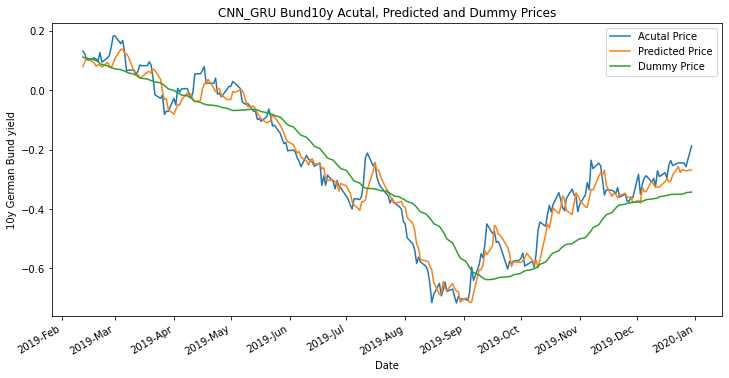

In [21]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

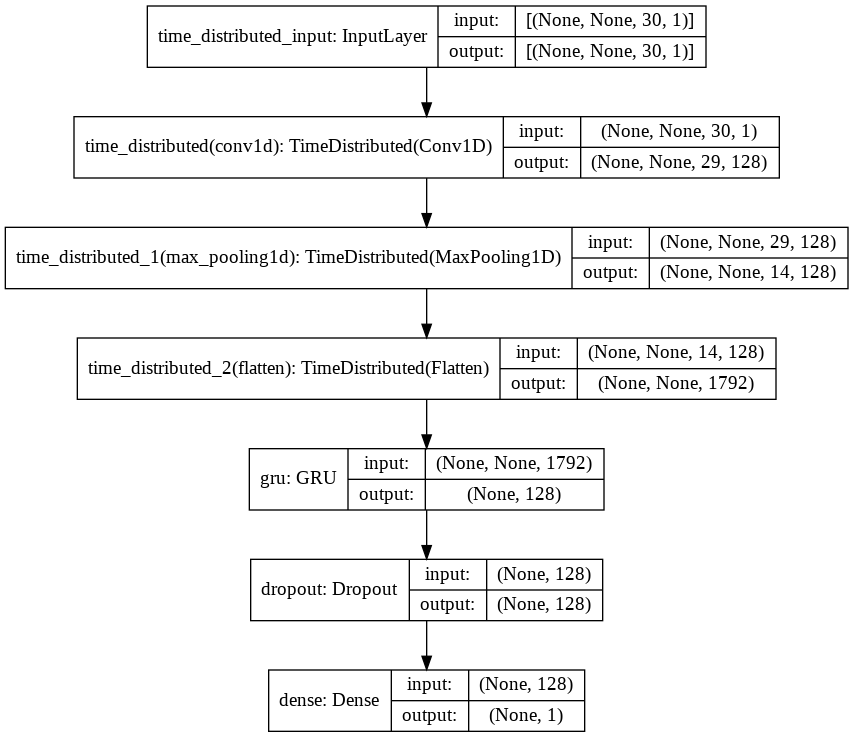

In [22]:
plot_model(model, show_shapes=True, expand_nested=True)

In [23]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.005915365779679101
RMSE:  0.07691141514547176
MAE:  0.0630986644734837
Dummy MSE:  0.01192499274023522
Dummy RMSE:  0.10920161509902324
Dummy MAE:  0.0887186459104488


In [24]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/CNN_GRU_Bund10y/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/CNN_GRU_Bund10y/assets
